In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from pathlib import Path as p
from sklearn.metrics import jaccard_score as js

In [2]:
#only variable that needs to be changed
#varibles = derivatives, template
work_dir = p('/media/Data/GoogleDriveNtust/dissertation_01/workFinal/workDir')
subcorticalTemplate = p('/media/Data/GoogleDriveNtust/dissertation_01/workSemiFinal/templates/SubcorticalTemplate')

In [3]:
#variables = pipeline2, jSResultsSubcortical, subCorticalImages, totalArray
derivatives = p(f'{work_dir}/test_dataset/derivatives')


pipeline2 = p(f'{derivatives}/pipeline_2')

os.chdir(derivatives)
os.chdir('../..')
results = os.getcwd()
outputResults = p(f'{results}/registration_results')
jSResultsSubcortical = p(f'{outputResults}/jaccardResultsSubcortical')
try:
    os.mkdir(jSResultsSubcortical)
except OSError:
    pass

registrationNames = os.listdir(pipeline2)
subjects = os.listdir(p(f'{pipeline2}/{registrationNames[0]}'))
imageList = ['-BrStem_corr.nii.gz', '-L_Pall_corr.nii.gz', '-L_Puta_corr.nii.gz', '-L_Thal_corr.nii.gz', '-R_Accu_corr.nii.gz', '-R_Amyg_corr.nii.gz', '-R_Caud_corr.nii.gz', '-R_Hipp_corr.nii.gz', '-R_Pall_corr.nii.gz', '-R_Puta_corr.nii.gz', '-R_Thal_corr.nii.gz', '-L_Accu_corr.nii.gz', '-L_Amyg_corr.nii.gz', '-L_Caud_corr.nii.gz', '-L_Hipp_corr.nii.gz']
labels = ['Brain Stem Fourth Ventricle', 'Left Pallidum', 'Left Putamen', 'Left Thalamus', 'Right Accumbens', 'Right Amygdala', 'Right Caudate', 'Right Hippocampus', 'Right Pallidum', 'Right Putamen', 'Right Thalamus', 'Left Accumbens', 'Left Amygdala', 'Left Caudate', 'Left Hippocampus']
title = ['Subcortical Structures']
title.extend(subjects)

title2 = ['Registration Software']
title2.extend(labels)

title3 = title2
title4 = title2

In [4]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -180),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90, color='white')

In [5]:
def js_multi(subcorticalStructureNameList):
    subjectSubcortical = p(f'{pipeline2}/{registrationNames[i]}/{subjects[j]}/{subjects[j]}{subcorticalStructureNameList}')
    templateSubcortical = p(f'{subcorticalTemplate}/template{subcorticalStructureNameList}')

    imgSubjectSubcortical = nib.load(subjectSubcortical)
    imgTemplateSubcortical = nib.load(templateSubcortical)

    imgDataSubjectSubcortical = imgSubjectSubcortical.get_fdata()
    imgDataTemplateSubcortical = imgTemplateSubcortical.get_fdata()

    c = imgDataSubjectSubcortical.flatten()
    d = imgDataTemplateSubcortical.flatten()
    jaccardScore = js(c.astype(bool),d.astype(bool))
    return jaccardScore

Initializing jaccard on ants
Initializing jaccard on antsQuick
Initializing jaccard on broccoli
Initializing jaccard on elastix
Initializing jaccard on fsl2mmThreaded
Initializing jaccard on spmPy


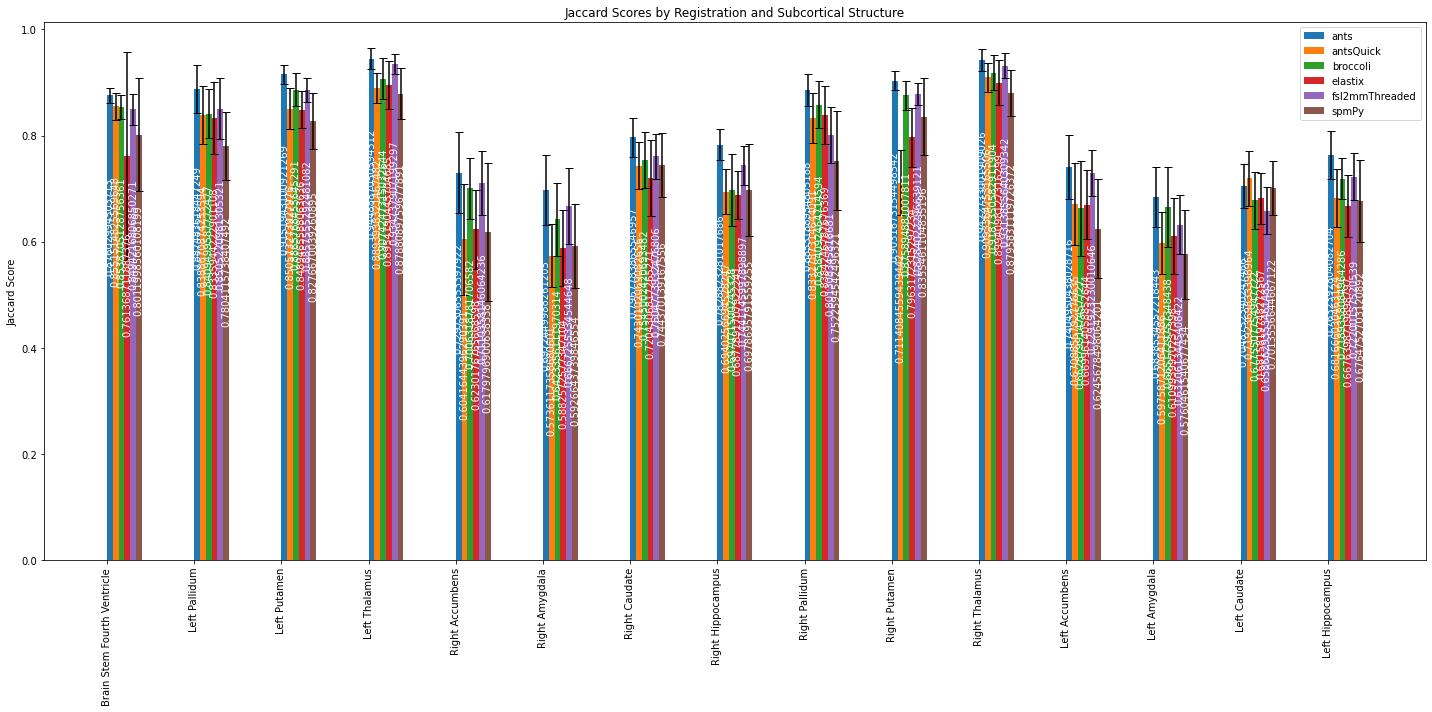

In [7]:
if __name__ == '__main__':
    
    x = np.arange(len(imageList)) 
    width = 1 / len(imageList)
    fig, ax = plt.subplots(figsize=(20, 10))
    
    for i in range(len(registrationNames)):
        resultArray = labels
        structureJaccardScore = []
        q1 = []
        w1 = []
        es = []
        q = ['Mean']
        w = ['Standard Deviation']
        print(f'Initializing jaccard on {registrationNames[i]}')
        for j in range(len(subjects)):
            pool = Pool(os.cpu_count()-2)
            a = pool.map(js_multi, imageList)
            pool.close()
            pool.join()
            resultArray = np.column_stack((resultArray, a))
        resultArrayPretty = np.vstack((title, resultArray))
        np.savetxt(p(f'{jSResultsSubcortical}/{registrationNames[i]}.csv'), resultArrayPretty, fmt='%s', delimiter = ',')
        
        means = []
        stds = []
        
        for k in range(len(imageList)):
            mean = np.mean(resultArray[k,1:].astype(np.float))
            std = np.std(resultArray[k,1:].astype(np.float))
            
            e = [f'{mean}u"\u00B1"{std}']
            es.append(e)
            means.append(mean)
            stds.append(std)
            
        structureJaccardScore.append(registrationNames[i])
        structureJaccardScore.extend(es)
        
        q1.append(registrationNames[i])
        q1.extend(means)
        
        w1.append(registrationNames[i])
        w1.extend(stds)
        
        title2 = np.vstack((title2, structureJaccardScore))
        title3 = np.vstack((title3, q1))
        title4 = np.vstack((title4, w1))
        
        rects = ax.bar(x + i*width, means, width, label=f'{registrationNames[i]}', yerr = stds, capsize=4, align='edge')
        autolabel(rects)
        
    np.savetxt(p(f'{jSResultsSubcortical}/JaccardScoreSubcortical.csv'), title2, fmt='%s', delimiter = ',') 
    np.savetxt(p(f'{jSResultsSubcortical}/JaccardScoreSubcorticalMean.csv'), title3, fmt='%s', delimiter = ',')
    np.savetxt(p(f'{jSResultsSubcortical}/JaccardScoreSubcorticalSTD.csv'), title4, fmt='%s', delimiter = ',')
    ax.set_ylabel('Jaccard Score')
    ax.set_title('Jaccard Scores by Registration and Subcortical Structure')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.xticks(rotation=90)
    fig.tight_layout()
    plt.savefig(p(f'{jSResultsSubcortical}/JCSubcortical.jpg'))
    plt.show()